In [1]:
import os
import numpy as np
from numpy.random import default_rng
from pyfitit.ihs import ihs
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# скорость белок задаютсся в мкл/сек
v1_s = 0.13
v1_e = 16
v1_d = 0.005
# скорость осадитель
v2_s = 0
v2_e = 16
v2_d = 0.005
# скорость разбавитель
v3_s = 0
v3_e = 40
v3_d = 0.005
# объем выдавливаемой смеси, мкл
volume = 25
# концентрации реагентов в шприцах
c1_def = 120
c2_def = 60
c3_def = 0
# области вариации концентраций в капле
c1_s = 0
c1_e = 60

c2_s = 0
c2_e = 30

In [3]:
def c_to_v(c_b, c_o):
    capa = (c1_def / c2_def) * c_o / c_b
    #    print(capa)
    # рассчет всех возможных комбинаций скоростей
    x = []
    for v3 in np.arange(v3_s, v3_e, v3_d):
        v_b = c_b * v3
        v_b /= c1_def - c_b * (1 + capa)
        v_o = capa * v_b
        # if -0.01<v_b-round(v_b,2)<0.01 and -0.001<v_o-round(v_o,2)<0.01:
        x.append((v_b, v_o, v3))
        # break
    # выбор тех что наиболее близки к округленному значению
    a = []
    for i in range(len(x)):
        if (-0.0001 < x[i][0] - round(x[i][0], 3) < 0.0001 and -0.0001 < x[i][1] - round(x[i][1],3) < 0.0001 ):
            if x[i][0] > v1_s and x[i][2] > v2_s:
                a.append(x[i])
    b = []
    # выбор тех кто лежат в пределе 10-20 секунд выкапывания
    for i in range(len(a)):
        sum = a[i][0] + a[i][1] + a[i][2]
        time = volume / (sum)

        if 2<time <60:
            b.append((a[i][0], a[i][1], a[i][2], time))
            break
    return b


# b[0],b[1],b[2],b[3]

In [24]:
c_to_v(60,0)

[(0.21, 0.0, 0.21, 59.523809523809526)]

для фикса

In [ ]:
mas = [
    [5, 15],
    [10, 28],
    [15, 8],
    [20, 24],
    [25, 6],
    [30, 0],
    [35, 30],
    [40, 17],
    [45, 10],
    [50, 26],
    [55, 3],
    [60, 15],
]
for i in range(len(mas)):
    plt.scatter(mas[i][0], mas[i][1])

In [ ]:
res = c_to_v(75.0, 22.1)
print(res)

для рандома ihs

3.9


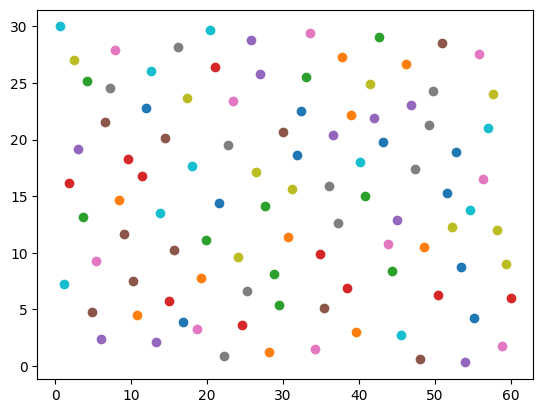

In [6]:
n = 100
bounds = [(0, 60), (0, 30)]
res = ihs(2, n, seed=random.seed())
samples = []
for row in res:
    r = []
    for i, interval in zip(range(len(row)), bounds):
        r.append(interval[0] + (row[i] * 1.0 / n) * (interval[1] - interval[0]))
    samples.append(r)
real_values = []

for s in samples:
    x1 = round(s[0], 6)
    x3 = round(s[1], 6)
    real_values.append([x1, x3])
df = pd.DataFrame(real_values)
# df = df.round(1)
# plt.scatter(df[0].values, df[2].values)
mas = df.values.tolist()
print(df[1][0])
for i in range(len(df)):
    plt.scatter(df[0][i], df[1][i])

In [7]:
res = []
for i in range(len(mas)):
    t = c_to_v(mas[i][0], mas[i][1])
    if len(t)>0:
        res.append(
            (
                mas[i][0],  # К белка
                mas[i][1],  # К осад
                t[0][0],  # v белка
                t[0][1],  # v осад
                t[0][2],  # v разбав
                t[0][3],  # время
                t[0][0] + t[0][1] + t[0][2],  # сум скорость
            )
        )
len(res)

98

In [8]:
df = pd.DataFrame(
    res, columns=["c белка", "c осад", "v белка", "v осад", "v разб", "time", "v sum"]
)
df = df.sort_values(by="c белка", ascending=True)
df = df.reset_index()
df
df.to_excel("точки ihs.xlsx", index=False)

In [17]:
table = []
wait = (0, 0, 0, 0, None, None, 300)
q = 0
v1 = 0
v2 = 0
time=0
c=0
for i in range(len(df)):
    c+=1
    v1 += df.loc[i]["v белка"] * df.loc[i]["time"]
    v2 += df.loc[i]["v осад"] * df.loc[i]["time"]
    time+=df.loc[i]["time"]
    time+=300
    if v1 > 240 or v2 > 240:
        v1 = 0
        v2 = 0
        print('заправка',v1, v2)
    if v1 > 240 or v2 > 240 or time >60*1*60:
        print(v1, v2, time,c)
        name = "расписание " + str(q) + ".xlsx"
        pd.DataFrame(table).to_excel(name)
        table = []
        time=0
        q += 1
        c=0
    table.append(
        (
            df.loc[i]["v белка"],
            df.loc[i]["v осад"],
            df.loc[i]["v разб"],
            0,
            None,
            None,
            df.loc[i]["time"],
        )
    )
    table.append(wait)

12.75 85.875 3692.0363558268273 12
43.5 152.25 3815.9109222866537 12
87.5 221.875 3612.673736556162 11
заправка 0 0
44.5 43.875 3661.0475399964143 11
118.75 112.875 3733.4691341753164 11
208.125 191.25 3721.3566177629477 11
заправка 0 0
68.25 39.125 3734.0290583330293 11
187.875 103.25 3695.649198864023 11
заправка 0 0


(0.0, 60.0)

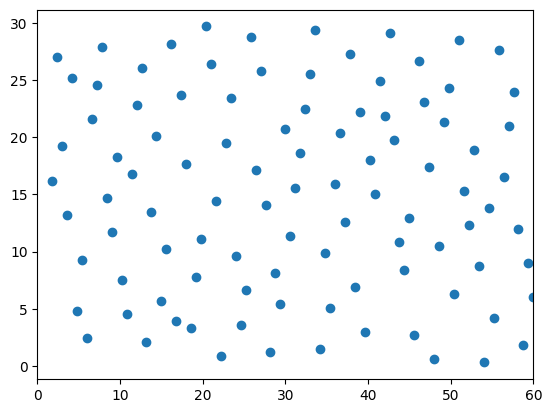

In [10]:
plt.scatter(df['c белка'],df['c осад'])
plt.xlim(0,60)